In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
import random

In [43]:
import seaborn as sns
sns.set_theme()

## 导入并划分数据

In [44]:
data = np.loadtxt("../data/Magic Dataset.txt")
X = data[:,:-1]
y = data[:,-1]
print(data.shape)
print(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print('train shape',X_train.shape)
print('test shape',X_test.shape)

(19020, 11)
[[0.074306 0.062415 0.208043 ... 0.445467 0.163066 1.      ]
 [0.082815 0.045727 0.170668 ... 0.070677 0.412679 1.      ]
 [0.478241 0.530579 0.626819 ... 0.855111 0.516926 1.      ]
 ...
 [0.215712 0.185389 0.445594 ... 0.336652 0.516377 2.      ]
 [0.352326 0.29995  0.606919 ... 0.940971 0.823491 2.      ]
 [0.554415 0.206728 0.374926 ... 0.5859   0.548344 2.      ]]
train shape (13314, 10)
test shape (5706, 10)


## 训练集RSP划分

In [45]:
def data2HDFS_RSP(data, K=65, M=20):
    ''''' 
    先按HDFS数据块划分，再划分为RSP数据块 
    K: HDFS 个数
    M: RSP个数
    '''  
    try:
        # 按顺序切分为k份  
        HDFS=np.array(np.split(data,K))  
        for i in range(HDFS.shape[0]):  
            np.random.shuffle(HDFS[i])  
        HDFS_list=[np.split(D_k,M) for D_k in HDFS]  
        # 划分RSP  
        RSP=[[D_K[m] for D_K in HDFS_list] for m in range(M)]  
        for idx,RSP_ in enumerate(RSP):  
            tmp_RSP=RSP_[0]  
            for i in range(1,len(RSP_)):  
                tmp_RSP=np.vstack((tmp_RSP,RSP_[i]))  
            RSP[idx]=tmp_RSP  
        RSP=np.array(RSP)  
    except:
        warnings.warn("wrong dimension of K and M")
    return (HDFS, RSP)


In [46]:
# 划分训练集
data_train = np.hstack([X_train, y_train[:,np.newaxis]])[:13000, :]

HDFS, RSP = data2HDFS_RSP(data_train, K=65, M=20)
print('HDFS: [块数: {0} 块内元素个数: {1} 数据块维度: {2}]'.format(  
    HDFS.shape[0],HDFS.shape[1],HDFS.shape[2]))  
print('RSP: [块数: {0} 块内元素个数: {1} 数据块维度: {2}]'.format(  
    RSP.shape[0],RSP.shape[1],RSP.shape[2]))  

HDFS: [块数: 65 块内元素个数: 200 数据块维度: 11]
RSP: [块数: 20 块内元素个数: 650 数据块维度: 11]


In [59]:
HDFS_list = [(HDFS[i,:,:-1],HDFS[i,:,-1]) for i in range(HDFS.shape[0])]

In [47]:
RSP_list = [(RSP[i,:,:-1],RSP[i,:,-1]) for i in range(RSP.shape[0])]

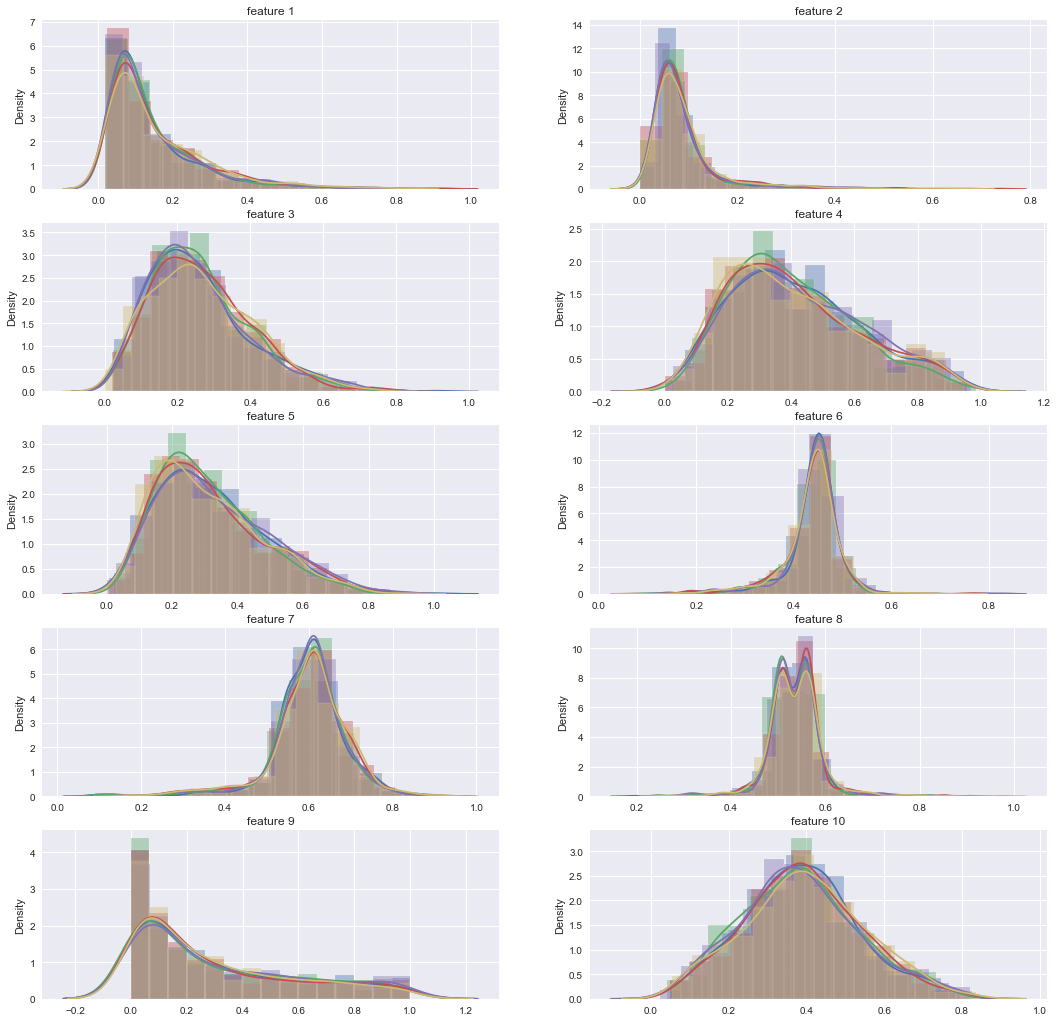

In [48]:
plt.style.use('seaborn')  
fig,axes = plt.subplots(ncols=2,nrows=5,figsize=[18,18]) 
RSP_sample = random.sample(list(range(X.shape[1])),5) 
for i,ax_ in enumerate(axes.flat[:10]):  
    ax_.set_title('feature '+str(i+1))  
    # RSP  
    for j in RSP_sample:
        sns.distplot(RSP[j,:,i],kde=True,ax=ax_,bins=15)  

## 模型训练

In [49]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from copy import deepcopy

In [50]:
# def plot_learningCurve(pipes, X, y):
#     #case1：学习曲线
#     #构建学习曲线评估器，train_sizes：控制用于生成学习曲线的样本的绝对或相对数量
#     train_sizes,train_scores, test_scores = learning_curve(estimator=pipes,X=X,y=y,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)
#     # cv = KFold(n_splits = 10)
#     # test_scores = cross_val_score(pipes, X_test, y_test, cv = cv)
#     # print(train_scores)
#     # print('train',train_scores.shape)
#     # print('test',test_scores.shape)
#     #统计结果
#     train_mean= np.mean(train_scores,axis=1)
#     train_std = np.std(train_scores,axis=1)
#     test_mean =np.mean(test_scores,axis=1)
#     test_std=np.std(test_scores,axis=1)
#     #绘制效果
#     plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
#     plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
#     plt.plot(train_sizes,test_mean,color='green',linestyle='--',marker='s',markersize=5,label='test accuracy')
#     plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')
#     plt.grid()
#     plt.xlabel('Number of training samples')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='lower right')
#     plt.title(pipes['clf'].__class__.__name__)
#     plt.show()

In [51]:
def plot_learningCurve_(pipes, X_train, y_train, X_test, y_test, train_sizes = 10):
    """
    绘制学习曲线图
    """
    train_score_list = []
    test_score_list = []
    nums_list = []
    for rate in np.linspace(0.05, 1, train_sizes):
        nums = int(X_train.shape[0]*rate)
        nums_list.append(nums)
        train_data = X_train[:nums,:]
        test_data = y_train[:nums,:]
        pipes.fit(train_data, test_data)
        # train
        train_score = cross_val_score(pipes, train_data, test_data, cv = 10)
        train_score_list.append(train_score)
        # test
        test_score = pipes.score(X_test, y_test)
        test_score_list.append(test_score)

    train_scores = np.array(train_score_list)
    test_scores = np.array(test_score_list)
    train_mean= np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)
    # test_mean =np.mean(test_scores,axis=1)
    # test_std=np.std(test_scores,axis=1)
    #绘制效果
    # train
    plt.figure(figsize=[12,8])
    plt.plot(nums_list,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
    plt.fill_between(nums_list,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
    # test
    plt.plot(nums_list,test_scores,color='green',linestyle='--',marker='s',markersize=5,label='test accuracy')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title(pipes['clf'].__class__.__name__)
    plt.show()


In [52]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    GaussianNB(),
]

pipeline_list = [
    Pipeline([('scl',StandardScaler()), ('clf',clf)])
    for clf in classifiers
]

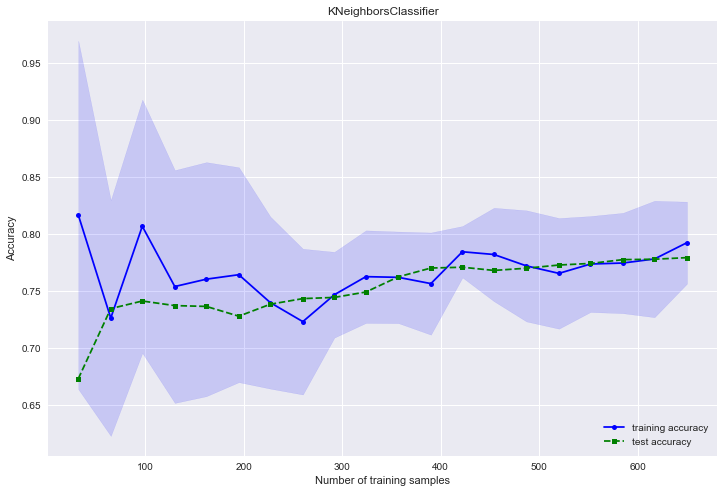

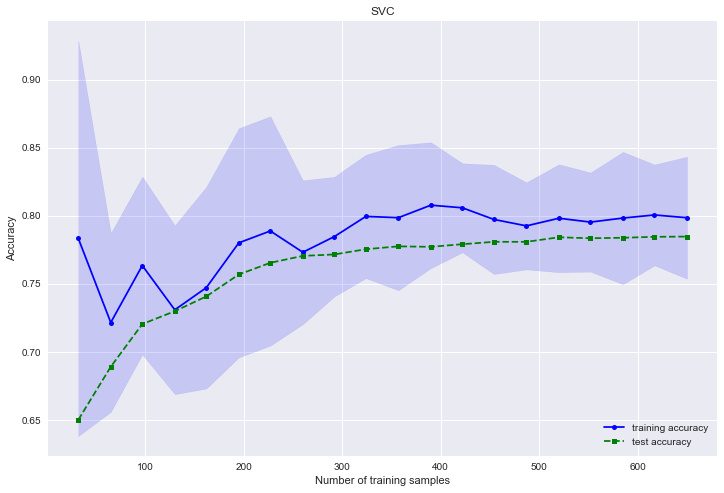

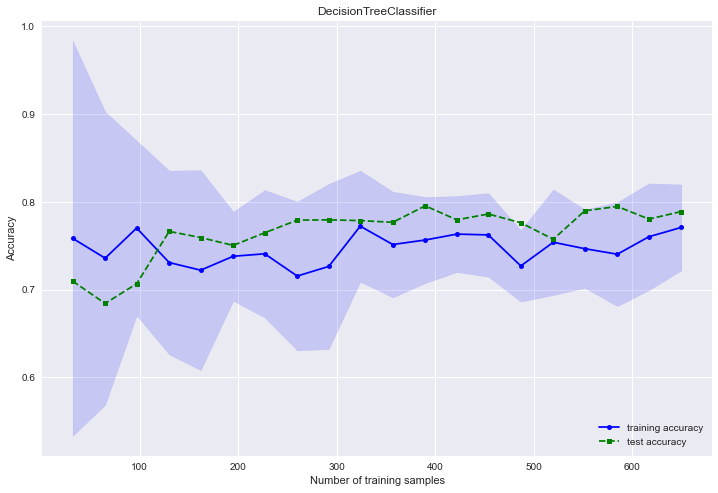

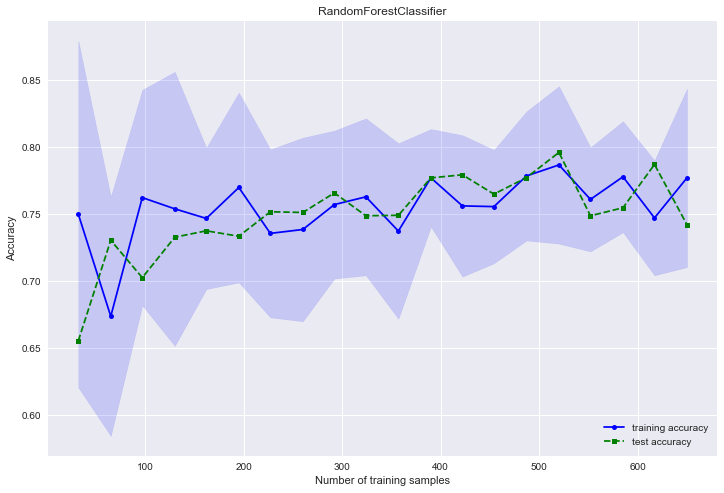

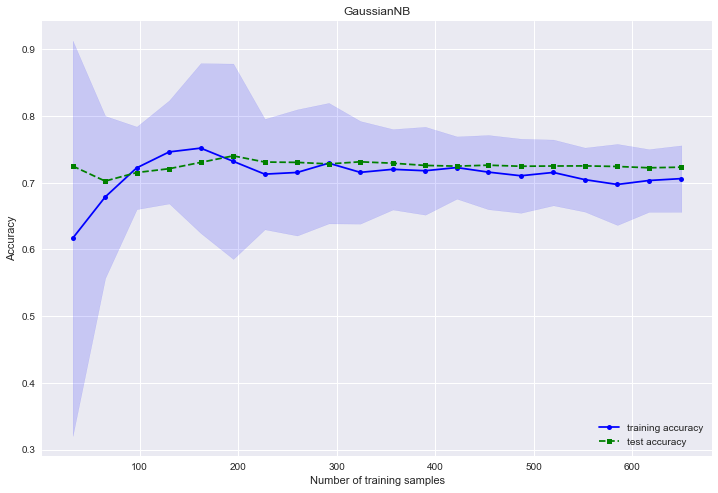

In [53]:
X_train_ = RSP_list[0][0]
y_train_ = RSP_list[0][1][:,np.newaxis]

for pipes in pipeline_list:
    plot_learningCurve_(pipes, X_train_, y_train_, X_test, y_test, train_sizes=20)

## 渐进融合 RSP

In [70]:
def score_(y_pred, y_test):
    correct = 0
    for i in range(y_pred.shape[0]):
        if y_pred[i] == y_test[i]:
            correct += 1 
    return correct/y_pred.shape[0]

def score_Test_ensemble(model_list, X_test, y_test):
    score_list = []
    for i in range(1,len(model_list)):# 渐进融合
        partial_list = []
        for clf in model_list[:i]:# 集成模型集合
            partial_list.append(clf.predict_proba(X_test))
        # 融合
        partial_list = np.mean(
            np.array(partial_list),
            axis=0
        )
        y_pred = np.array([1 if x[0]>=x[1]else 2 for x in partial_list])
        score_list.append(score_(y_pred, y_test))
    return score_list

def plot_ensemble_curve(model_score, name_model, stride=1):
    plt.figure(figsize=[12,8])
    for score_list, name in zip(model_score, name_model):
        plt.plot(range(len(score_list)),score_list, 'o--', label = name)
    _ = plt.xticks(range(0, len(score_list), stride))
    plt.legend()
    plt.xlabel('estimators nums')
    plt.ylabel('accuracy')

def plot_curve(score_list, name, stride=1):
    plt.figure(figsize=[12,8])
    plt.plot(range(len(score_list)),score_list, 'o--', label = name)
    _ = plt.xticks(range(0, len(score_list), stride))
    plt.title(name)
    plt.xlabel('estimators nums')
    plt.ylabel('accuracy')

In [55]:
decisionTree_list = []
naiveBayes_list = []
KNN_list = []
SVC_list = []
RandomForest_list = []
for X_rsp, y_rsp in RSP_list:
    decisionTree_list.append(
        Pipeline([('scl',StandardScaler()), ('clf',DecisionTreeClassifier(max_depth=5))]).fit(X_rsp, y_rsp)
    )
    naiveBayes_list.append(
        Pipeline([('scl',StandardScaler()), ('clf',GaussianNB())]).fit(X_rsp, y_rsp)
    )
    KNN_list.append(
        Pipeline([('scl',StandardScaler()), ('clf',KNeighborsClassifier(3))]).fit(X_rsp, y_rsp)
    )
    SVC_list.append(
        Pipeline([('scl',StandardScaler()), ('clf',SVC(kernel="rbf", C=1, probability=True))]).fit(X_rsp, y_rsp)
    )
    # RandomForest_list.append(
    #     Pipeline([('scl',StandardScaler()), ('clf',RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1))]).fit(X_rsp, y_rsp)
    # )

In [56]:
model_score = []
name_model = []
for i, model_list in enumerate([decisionTree_list, naiveBayes_list, KNN_list, SVC_list]):
    name = str(model_list[0]['clf']).split('(')[0]
    print(name)
    name_model.append(name)
    model_score.append(score_Test_ensemble(model_list, X_test, y_test))

DecisionTreeClassifier
GaussianNB
KNeighborsClassifier
SVC


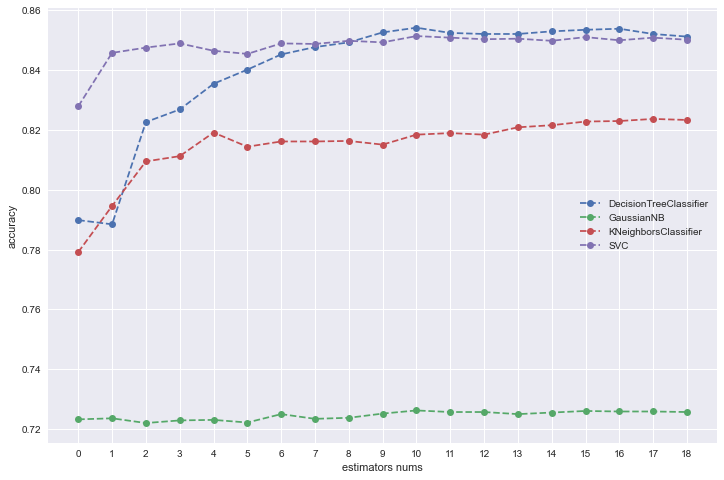

In [57]:
plot_ensemble_curve(model_score, name_model)

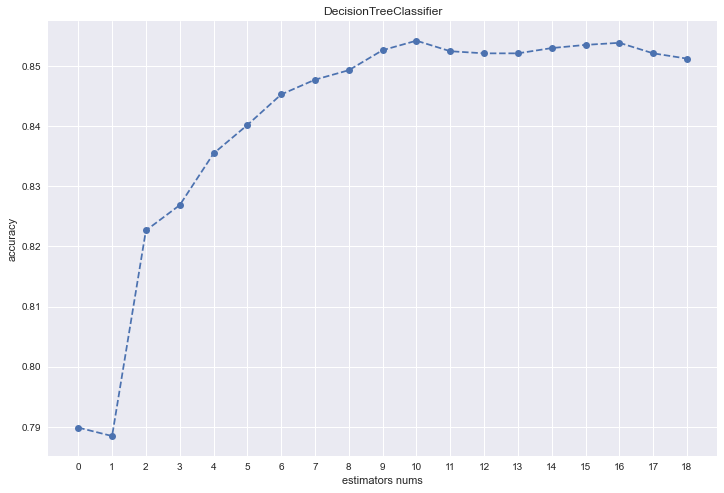

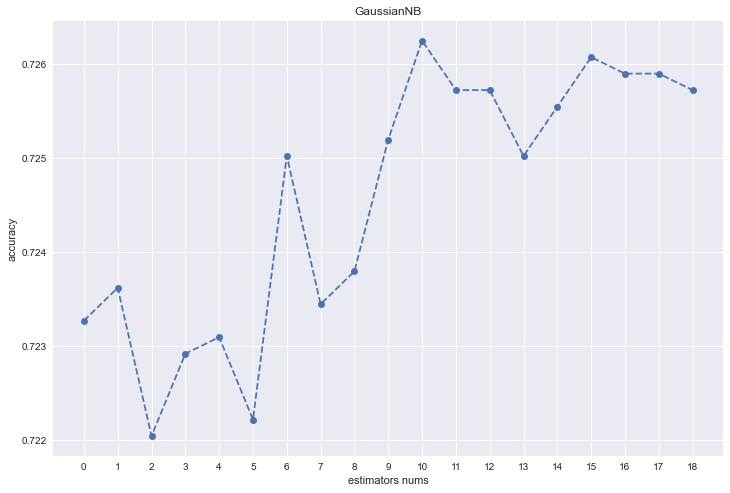

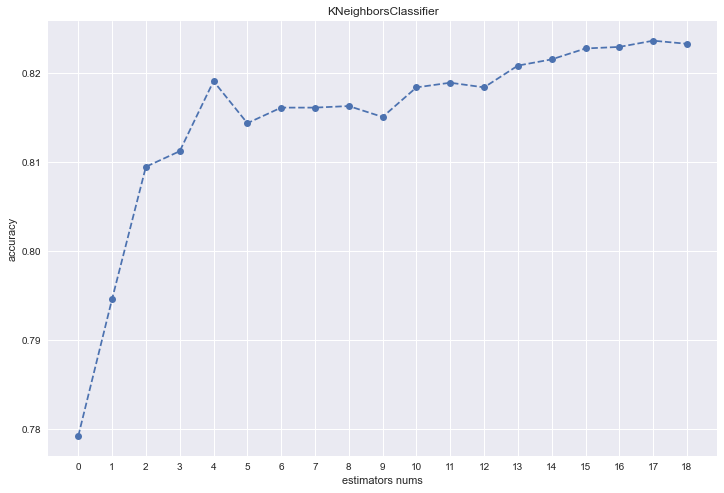

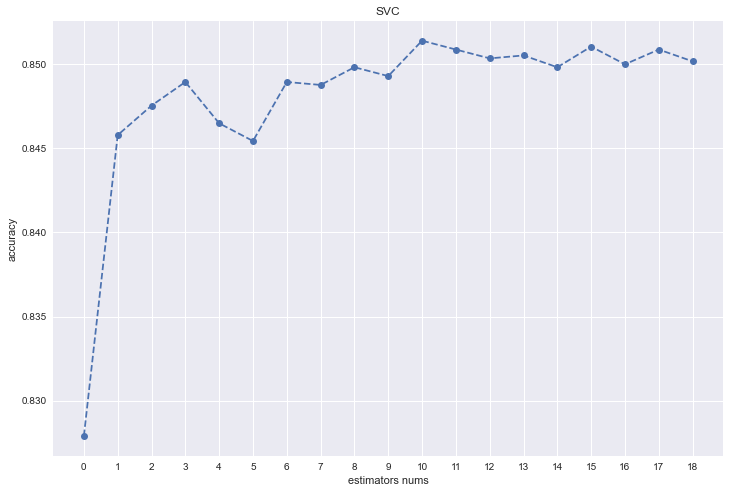

In [58]:
for i in range(len(model_score)):
    plot_curve(model_score[i], name_model[i])

## 渐进融合 HDFS

In [64]:
decisionTree_list = []
naiveBayes_list = []
KNN_list = []
SVC_list = []
RandomForest_list = []
for X_hdfs, y_hdfs in HDFS_list:
    decisionTree_list.append(
        Pipeline([('scl',StandardScaler()), ('clf',DecisionTreeClassifier(max_depth=5))]).fit(X_hdfs, y_hdfs)
    )
    naiveBayes_list.append(
        Pipeline([('scl',StandardScaler()), ('clf',GaussianNB())]).fit(X_hdfs, y_hdfs)
    )
    KNN_list.append(
        Pipeline([('scl',StandardScaler()), ('clf',KNeighborsClassifier(3))]).fit(X_hdfs, y_hdfs)
    )
    SVC_list.append(
        Pipeline([('scl',StandardScaler()), ('clf',SVC(kernel="rbf", C=1, probability=True))]).fit(X_hdfs, y_hdfs)
    )
    # RandomForest_list.append(
    #     Pipeline([('scl',StandardScaler()), ('clf',RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1))]).fit(X_rsp, y_rsp)
    # )

In [65]:
model_score = []
name_model = []
for i, model_list in enumerate([decisionTree_list, naiveBayes_list, KNN_list, SVC_list]):
    name = str(model_list[0]['clf']).split('(')[0]
    print(name)
    name_model.append(name)
    model_score.append(score_Test_ensemble(model_list, X_test, y_test))

DecisionTreeClassifier
GaussianNB
KNeighborsClassifier
SVC


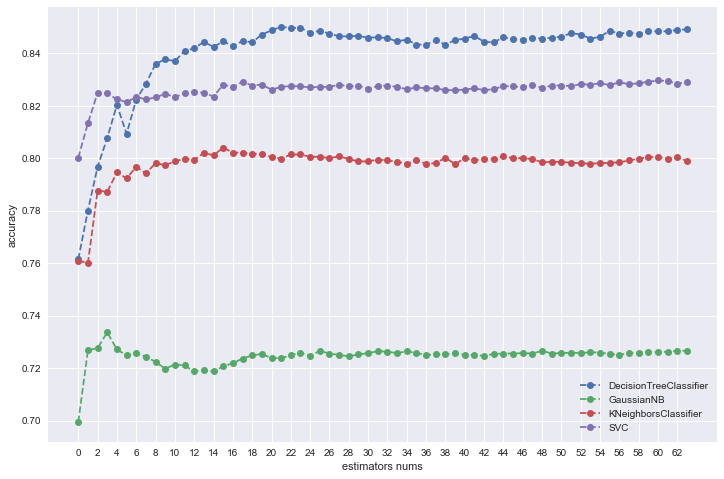

In [74]:
plot_ensemble_curve(model_score, name_model, stride=2)

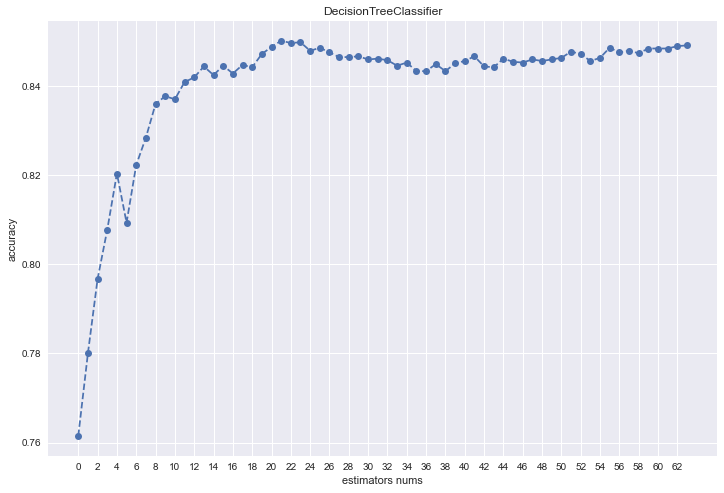

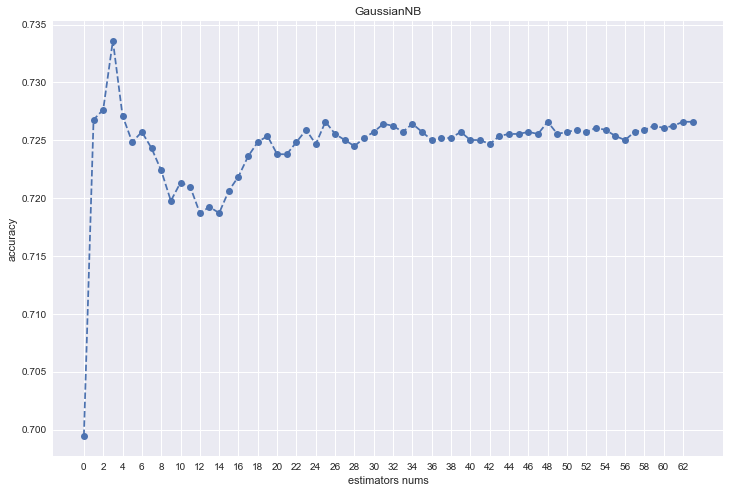

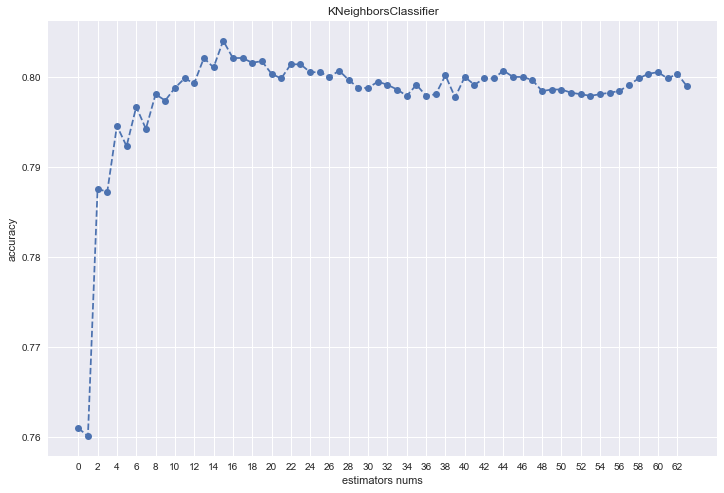

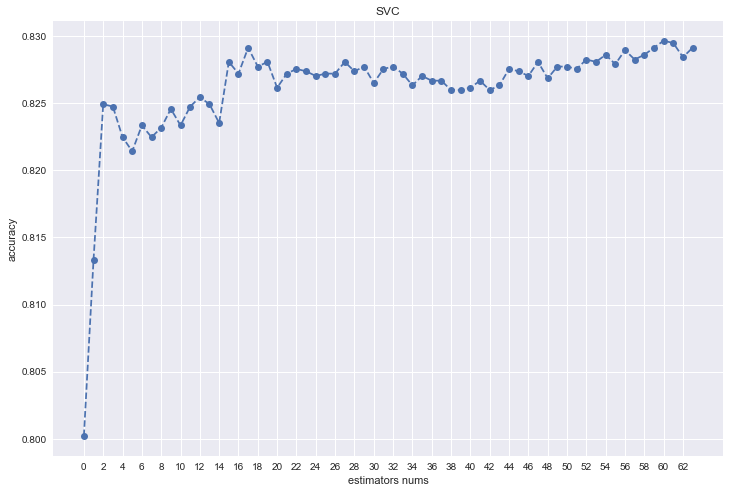

In [75]:
for i in range(len(model_score)):
    plot_curve(model_score[i], name_model[i], 2)